In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt



In [72]:
#let's make another branching model
class branching_model:
    def __init__(self,
                 rho,
                 d,
                 v,
                 c,
                 dist):
        self.rho = rho
        self.d = d
        self.cure_rate= float(1)/d
        self.v = v
        self.c =c 
        self.dist = dist
        self.mu = np.arange(len(dist)).dot(np.array(dist))
        
        print("R0 equal to "+str(rho*self.mu*d))
        
        
    def simulate(self):
        I = 10
        upper_bound = 30000
        Is =[I]
        R0_est = []
        
        diff_est = 0
        
        Reff_est = []
        
        vs = []
        
        
        while True:
            new_infecs = 0
            for i in range(I):
                num_edges = np.random.choice(len(self.dist),p=self.dist)
                for j in range(num_edges):
                    if np.random.rand() < self.rho:
                        new_infecs+=1
                
                if np.random.rand() < self.v:
                    new_infecs -=1
                
                    num_edges = np.random.choice(len(self.dist),p=self.dist)
                    
                    for j in range(num_edges):
                        if np.random.rand() < self.c*self.rho:
                            new_infecs -=1
                    
                else:
                    if np.random.rand() < self.cure_rate:
                        new_infecs -=1
                
            
            new_I = max([0,I + new_infecs])
            I = new_I
            Is.append(I)
            growth_rate = float(Is[-1]-Is[-2])/float(Is[-2])
            
            
            #if doing average over all data (fixed v)
#             diff_est*= (len(Is)-2)
#             diff_est += growth_rate
#             diff_est /=float(len(Is)-1)
            
            #if doing rolling average (dynamic v)
            diff_est = .95*diff_est + .05*growth_rate
            
            R0_est_val = (self.d/(1-self.c*self.v))*(diff_est+self.v+((1-self.v)/self.d))
            R0_est.append(R0_est_val)
            Reff_est_val = R0_est_val*((1-self.v*self.c)/(1+self.v*(self.d-1)))
            Reff_est.append(Reff_est_val)
            
            phat = .9/R0_est_val
            vnew = (1-phat)/(phat*(self.d-1)+self.c)
            
            #do adaptive control:
            self.v += .025*(vnew -self.v)
            vs.append(self.v)
            
            
            
            if I >upper_bound:
                break
            if I <= 0:
                break
            
        plt.figure()
        plt.plot(Is)
        plt.title('infections')
        plt.show()
        
        plt.figure()
#         plt.plot(R0_est, label = 'R0 Ests')
#         plt.plot(np.arange(len(R0_est)), (self.d*self.rho*self.mu)*np.ones(len(R0_est)), label = 'true R0')
        plt.title('Estimates')
        
        
        Reff_desired = .9
        
#         print(Reff_true)
        
        plt.plot(Reff_est, label = 'Reff Ests')
        plt.plot(np.arange(len(Reff_est)), Reff_desired*np.ones(len(Reff_est)), label = 'Nominal Reff')
        plt.plot(vs,label = 'testing rates')
        plt.legend()
        plt.show()
        
        return Is,Reff_est,Reff_desired,vs
            

R0 equal to 5.1639908265145


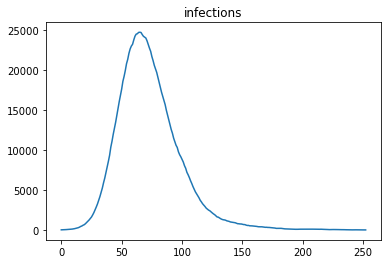

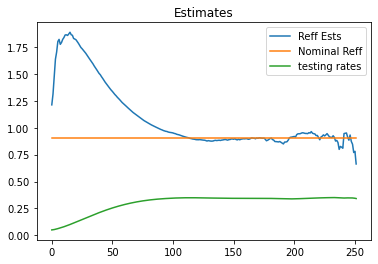

In [73]:
rho =.1
d = 14
v = .05
c = .2
dist = np.exp(-.1*np.arange(10))
dist/=np.sum(dist)
model = branching_model(rho,d,v,c,dist)

Is,Reff_est,Reff_desired,vs = model.simulate()

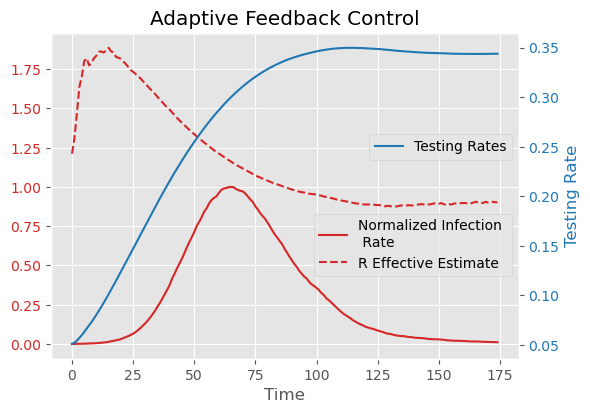

In [104]:



t = np.arange(175)



plt.style.use('ggplot')

fig, ax1 = plt.subplots(figsize = (6,4))

color = 'tab:red'
ax1.set_xlabel('Time')
# ax1.set_ylabel('exp', color=color)
ax1.plot(t, np.array(Is[:175])/max(Is), color=color, label = 'Normalized Infection \n Rate')
ax1.plot(t,Reff_est[:175],color = color,label = 'R Effective Estimate', linestyle = "--")
ax1.tick_params(axis='y', labelcolor=color)
# ax1.grid(b=False)
ax1.legend(loc = 'center right',bbox_to_anchor=(0.5, .1, 0.5, 0.5))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Testing Rate', color=color)  # we already handled the x-label with ax1
ax2.plot(t, vs[:175], color=color, label = 'Testing Rates')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc = 'center right', bbox_to_anchor=(0.5, .4, 0.5, 0.5))

ax2.grid(b=False)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Adaptive Feedback Control')
plt.savefig('ReffFeedback.png')
plt.show()